In [ ]:
# Python Version : 3.12.8
import pandas as pd # pandas version : 2.2.3
import math
import os
import subprocess
import re
from datetime import datetime  
from joblib import Parallel, delayed # joblib version : 1.4.2
import csv
import time

# =============================================================================
# 1. LKH를 이용한 초기해 도출 및 정수 리스트 변환
# =============================================================================

# --- 설정 ---
data_file = "C:\\data\\산타배송최적화\data.csv"  # 데이터 파일 경로
lkh_dir = "C:\\data\\산타배송최적화\\LKH\\"          # LKH 실행 파일이 있는 디렉토리
solution_dir = os.path.join(lkh_dir, "solutions")       # 솔루션 저장 경로
os.makedirs(solution_dir, exist_ok=True)

# --- 데이터 로드 ---
data_df = pd.read_csv(data_file)
data_df = data_df.sort_values(by='point_id').reset_index(drop=True)

# 출발지(DEPOT) 및 마을 데이터 분리
depot_data = data_df[data_df['point_id'] == 'DEPOT'].iloc[0]
towns_data = data_df[data_df['point_id'] != 'DEPOT'].reset_index(drop=True)
demands = [0] + list(towns_data['demand'])  # DEPOT은 수요량 0

# DEPOT는 노드 1, 마을은 노드 2부터 시작 (예: TOWN_01 → 노드 2)
locations_dict = {1: (depot_data['x'], depot_data['y'])}
for i, row in towns_data.iterrows():
    locations_dict[i + 2] = (row['x'], row['y'])

vehicle_capacity = 25

# --- 유클리드 거리 계산 (소수점 2자리 반올림) ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- LKH용 .tsp 파일 생성 ---
tsp_filename = os.path.join(lkh_dir, "santa_vrp.tsp")
def create_tsp_file():
    num_nodes = len(locations_dict)
    assert num_nodes == len(demands), "노드 수와 수요량 개수가 다름!"
    with open(tsp_filename, 'w') as f:
        f.write("NAME: Santa_VRP\n")
        f.write("TYPE: CVRP\n")
        f.write(f"DIMENSION: {num_nodes}\n")
        f.write("EDGE_WEIGHT_TYPE: EUC_2D\n")
        f.write(f"CAPACITY: {vehicle_capacity}\n")
        f.write("NODE_COORD_SECTION\n")
        for node in sorted(locations_dict.keys()):
            x, y = locations_dict[node]
            f.write(f"{node} {x} {y}\n")
        f.write("DEMAND_SECTION\n")
        for i, demand in enumerate(demands):
            f.write(f"{i + 1} {demand}\n")
        f.write("DEPOT_SECTION\n1\n-1\n")
        f.write("EOF\n")

# --- LKH용 .par 파일 생성 ---
par_filename = os.path.join(lkh_dir, "santa_vrp.par")
def create_par_file():
    with open(par_filename, 'w') as f:
        f.write(f"PROBLEM_FILE = {tsp_filename}\n")
        f.write(f"OUTPUT_TOUR_FILE = {os.path.join(lkh_dir, 'solution.txt')}\n")
        f.write("TRACE_LEVEL = 1\n")
        f.write("MAX_TRIALS = 10000\n")
        f.write("RUNS = 1\n")
        f.write("TIME_LIMIT = 36000\n")  # 10시간 제한
        f.write("INITIAL_TOUR_ALGORITHM = CVRP\n")
        f.write("SEED = 210\n")

# --- LKH 실행 및 모니터링 ---
def run_lkh_and_monitor():
    process = subprocess.Popen([os.path.join(lkh_dir, "LKH-3.exe"), par_filename],
                               cwd=lkh_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    target_solution_file = None
    target_found = False
    target_match = None

    # stdout의 모든 라인을 읽습니다.
    while True:
        line = process.stdout.readline()
        if not line:
            break
        print(line, end='')
        # 목표 COST 0.2170 감지 (정규 표현식)
        match = re.search(r'\* (\d+): Cost = (0_2170), Time = ([\d.]+) sec\.', line)
        if match:
            print("\n목표 COST 0.2170 발견! LKH 종료 준비 중...\n")
            target_found = True
            target_match = match
            # 강제 종료 전에 추가 출력이 기록될 수 있도록 반복문 탈출
            break

    if target_found:
        # LKH가 tour 파일에 데이터를 기록할 시간을 주기 위해 잠시 대기
        time.sleep(3)
        try:
            process.terminate()
            process.wait(timeout=10)
        except Exception as e:
            print("프로세스 종료 중 오류 발생:", e)
        
        iteration = int(target_match.group(1))
        cost = target_match.group(2).replace("_", ".")
        time_val = float(target_match.group(3))
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = os.path.join(solution_dir, f"solution_iter{iteration}_cost{cost}_{timestamp}.txt")

        tour_file = os.path.join(lkh_dir, "solution.txt")
        # solution.txt 파일이 생성될 때까지 대기 (최대 10초)
        for _ in range(10):
            if os.path.exists(tour_file):
                break
            time.sleep(1)

        tour = []
        if os.path.exists(tour_file):
            with open(tour_file, "r") as tf:
                tour_lines = tf.readlines()
            # "TOUR_SECTION"을 포함하는 라인을 찾습니다.
            tour_section_idx = None
            for i, line in enumerate(tour_lines):
                if "TOUR_SECTION" in line:
                    tour_section_idx = i
                    break
            if tour_section_idx is not None:
                # TOUR_SECTION 이후부터 "-1"이 나타날 때까지 정수형 노드를 읽습니다.
                for line in tour_lines[tour_section_idx+1:]:
                    line_stripped = line.strip()
                    if line_stripped == "-1":
                        break
                    try:
                        tour.append(int(line_stripped))
                    except ValueError:
                        continue
        else:
            print("solution.txt 파일이 존재하지 않습니다.")

        with open(output_file, "w") as f:
            f.write(f"Iteration: {iteration}, Cost: {cost}, Time: {time_val} sec\n")
            f.write("Optimal Route:\n")
            if tour:
                f.write(" -> ".join(map(str, tour)) + "\n")
            else:
                f.write("Route not available\n")

        print(f"목표 솔루션 저장 완료: {output_file}")
        target_solution_file = output_file

    process.stdout.close()
    process.stderr.close()
    return target_solution_file

# --- 솔루션 파일 분석 (텍스트 경로 생성) ---
def parse_lkh_solution(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    iteration = re.search(r"Iteration: (\d+)", lines[0]).group(1)
    cost = re.search(r"Cost: ([\d_]+)", lines[0]).group(1).replace("_", ".")
    time_val = re.search(r"Time: ([\d.]+) sec", lines[0]).group(1)

    # TOUR_SECTION 아래 한 줄에 경로가 " -> " 구분자로 기록됨
    route_start = lines.index("Optimal Route:\n") + 1
    route_line = lines[route_start].strip()
    if route_line == "Route not available":
        # 경로가 없는 경우 빈 리스트로 처리
        route = []
    else:
        route = list(map(int, route_line.split(" -> ")))

    # 텍스트 경로 생성: depot은 노드 1 또는 (node >= 77)로 처리, 나머지는 마을로 간주
    parsed_routes = []
    current_route = ["DEPOT"]
    for node in route:
        if node == 1 or node >= 77:
            if len(current_route) > 1:
                current_route.append("DEPOT")
                parsed_routes.append(current_route)
                current_route = ["DEPOT"]
        else:
            # 마을 노드: .tsp 파일에서는 마을이 노드 2부터 시작하므로, node-1 사용
            current_route.append(f"TOWN_{node - 1:02d}")
    if len(current_route) > 1:
        current_route.append("DEPOT")
        parsed_routes.append(current_route)

    return iteration, cost, time_val, parsed_routes

# --- 정수 리스트 변환 함수 ---
def convert_parsed_routes_to_int_lists(parsed_routes):
    """
    각 경로에서 "DEPOT"은 0, "TOWN_XX"는 XX(정수)로 변환합니다.
    예) ["DEPOT", "TOWN_22", "TOWN_20", "DEPOT"] → [0, 22, 20, 0]
    """
    int_routes = []
    for route in parsed_routes:
        int_route = []
        for node in route:
            if node == "DEPOT":
                int_route.append(0)
            else:
                m = re.search(r"TOWN_(\d+)", node)
                if m:
                    int_route.append(int(m.group(1)))
        int_routes.append(int_route)
    return int_routes

# --- 실행: LKH 초기해 도출 ---
print("TSP & PAR 파일 생성 중...")
create_tsp_file()
create_par_file()
print("파일 생성 완료!")

print("\nLKH 실행 중...")
solution_file = run_lkh_and_monitor()

if solution_file:
    print("\n목표 COST 0.2170 솔루션 발견! (LKH 결과)")
    iteration, cost, time_val, parsed_routes = parse_lkh_solution(solution_file)

    # 텍스트 형태 경로 출력 (옵션)
    formatted_routes = [
        f'Route {i + 1}: "{" -> ".join(route)}" (Distance: {0} km)'
        for i, route in enumerate(parsed_routes)
    ]
    print(f"Iteration: {iteration}, Cost: {cost}, Time: {time_val} sec")
    print("\n".join(formatted_routes))
    
    # 정수 리스트 형태 경로 (최적화에 사용할 초기 경로)
    initial_routes = convert_parsed_routes_to_int_lists(parsed_routes)
    print("\nInteger Route Representation (초기 경로):")
    for route in initial_routes:
        print(route)
else:
    print("LKH 솔루션 파일을 찾지 못했습니다.")
    initial_routes = []  # 빈 리스트 처리

# =============================================================================
# 2. 4-opt 최적화를 이용한 경로 개선 (초기 경로: LKH 결과의 정수 리스트)
# =============================================================================
if initial_routes:
    # --- 최적화용 데이터 준비 ---
    # 최적화에서는 depot을 index 0, towns는 index 1부터 사용하므로 아래와 같이 생성합니다.
    opt_locations = [(depot_data['x'], depot_data['y'])] + list(zip(towns_data['x'], towns_data['y']))
    num_locations = len(opt_locations)
    depot_index = 0

    # 거리 행렬 생성
    distance_matrix = [[0] * num_locations for _ in range(num_locations)]
    for i in range(num_locations):
        for j in range(num_locations):
            distance_matrix[i][j] = euclidean_distance(opt_locations[i], opt_locations[j])

    # --- Fitness 함수 (패널티 적용) ---
    def fitness(route):
        total_distance = 0
        current_capacity = 0
        current_position = depot_index
        for i in range(1, len(route)):
            next_node = route[i]
            if next_node != depot_index:
                current_capacity += demands[next_node]
            penalty = 0
            if current_capacity > vehicle_capacity:
                penalty = (current_capacity - vehicle_capacity) * 50
            total_distance += distance_matrix[current_position][next_node] + penalty
            current_position = next_node
            if next_node == depot_index:
                current_capacity = 0
        return total_distance

    # --- 4-opt 알고리즘 ---
    def four_opt(route, distance_matrix):
        best_route = route
        best_distance = fitness(route)
        improved = True

        while improved:
            improved = False

            neighborhoods = [
                (i, j, k, l) for i in range(1, len(route) - 3)
                for j in range(i + 1, len(route) - 2)
                for k in range(j + 1, len(route) - 1)
                for l in range(k + 1, len(route))
            ]

            # 병렬 처리로 가능한 스왑 후보 평가
            results = Parallel(n_jobs=-1)(
                delayed(lambda i, j, k, l: [
                    (route[:i] + route[i:j][::-1] + route[j:k][::-1] + route[k:l][::-1] + route[l:], 
                     fitness(route[:i] + route[i:j][::-1] + route[j:k][::-1] + route[k:l][::-1] + route[l:])),
                    (route[:i] + route[k:l] + route[j:k] + route[i:j] + route[l:], 
                     fitness(route[:i] + route[k:l] + route[j:k] + route[i:j] + route[l:])),
                    (route[:i] + route[j:k] + route[i:j] + route[k:l] + route[l:], 
                     fitness(route[:i] + route[j:k] + route[i:j] + route[k:l] + route[l:])),
                    (route[:i] + route[j:k] + route[k:l] + route[i:j] + route[l:], 
                     fitness(route[:i] + route[j:k] + route[k:l] + route[i:j] + route[l:])),
                    (route[:i] + route[k:l][::-1] + route[j:k][::-1] + route[i:j][::-1] + route[l:], 
                     fitness(route[:i] + route[k:l][::-1] + route[j:k][::-1] + route[i:j][::-1] + route[l:])),
                    (route[:i] + route[k:l] + route[i:j][::-1] + route[j:k] + route[l:], 
                     fitness(route[:i] + route[k:l] + route[i:j][::-1] + route[j:k] + route[l:])),
                    (route[:i] + route[i:j][::-1] + route[k:l][::-1] + route[j:k][::-1] + route[l:], 
                     fitness(route[:i] + route[i:j][::-1] + route[k:l][::-1] + route[j:k][::-1] + route[l:]))
                ])(i, j, k, l)
                for i, j, k, l in neighborhoods
            )

            for swaps in results:
                for new_route, new_distance in swaps:
                    if new_distance < best_distance:
                        best_route = new_route
                        best_distance = new_distance
                        improved = True
            # 경로가 개선되었으면 route 업데이트
            route = best_route

        return best_route, best_distance

    # --- 경로 거리 계산 함수 ---
    def calculate_route_distance(route, distance_matrix):
        total_distance = 0
        for i in range(1, len(route)):
            total_distance += distance_matrix[route[i-1]][route[i]]
        return total_distance

    # --- 각 초기 경로에 대해 4-opt 최적화 실행 ---
    optimized_routes = []
    for route in initial_routes:
        opt_route, opt_distance = four_opt(route, distance_matrix)
        optimized_routes.append(opt_route)

    total_initial_distance = sum(calculate_route_distance(route, distance_matrix) for route in initial_routes)
    total_optimized_distance = sum(calculate_route_distance(route, distance_matrix) for route in optimized_routes)

    # --- 결과 출력 ---
    print("\n================ 최적화 결과 ================")
    print("초기 경로 (정수 리스트) (before 4-opt algorithm):")
    for route in initial_routes:
        print(route)
    print("\n최적화된 경로: (after 4-opt algorithm)")
    for route in optimized_routes:
        print(route)
    print(f"\nTotal initial distance: {total_initial_distance}")
    print(f"Total optimized distance: {total_optimized_distance}")
else:
    print("최적화할 초기 경로가 없습니다.")

# =============================================================================
# 3. 최적화된 경로를 Submission 파일로 저장 (CSV 파일 생성)
# =============================================================================
if optimized_routes:
    # 숫자 경로 데이터를 "DEPOT" 및 "TOWN_XX" 형식으로 변환하는 함수
    def convert_to_labels(route):
        return ["DEPOT" if town == 0 else f"TOWN_{town:02d}" for town in route]

    # 변환된 경로 데이터 (각 경로를 리스트로 변환)
    routes_labels = [convert_to_labels(route) for route in optimized_routes]

    # 저장할 파일 경로
    output_path = os.path.join(lkh_dir, "submission.csv")

    # CSV 파일에 1열 형태로 저장 (각 행에 하나의 point_id를 기록)
    with open(output_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["point_id"])  # 첫 번째 열 이름 추가
        for route in routes_labels:
            for town in route:
                writer.writerow([town])  # 각 DEPOT 또는 TOWN_XX를 한 행씩 저장

    print(f"\nSubmission file saved to {output_path}")
else:
    print("최적화된 경로가 없어 submission 파일을 생성하지 못했습니다.")


TSP & PAR 파일 생성 중...
파일 생성 완료!

LKH 실행 중...
PARAMETER_FILE = C:\data\산타배송최적화\LKH\santa_vrp.par
Reading PROBLEM_FILE: "C:\data\산타배송최적화\LKH\santa_vrp.tsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = ALPHA
# DISTANCE =
DEPOT = 1
# EDGE_FILE =
EXCESS = 0.0131579
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 100
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = CVRP
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
K = 0
KICK_TYPE = 0
KICKS = 1
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 76
MAX_TRIALS = 10000
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
MTSP_MIN_SIZE = 1
MTSP_MAX_SIZE = 75
# MTSP_SOLUTION_FILE = 
# NONSEQUENTIAL_MOVE_TYPE = 5
# OPTIMUM =
OUTPUT_TOUR_FILE = C:\data\산타배송최적화\LKH\solution.txt
PATCHING_A = 1 
PATCHING_C = 0 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
P

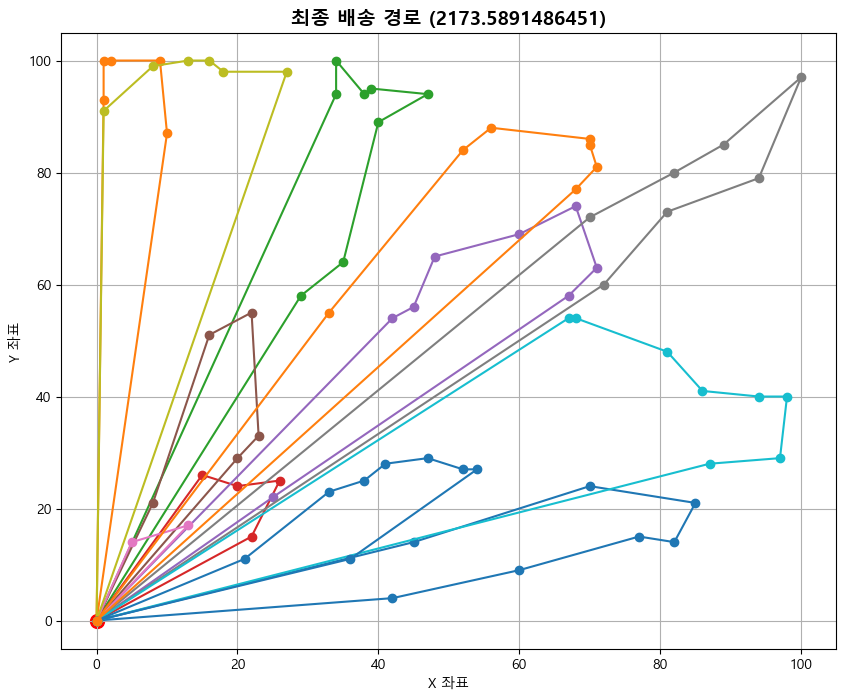

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 로드
data_file = "C:\\data\\산타배송최적화\\data.csv"  # 실제 데이터 경로로 변경
data_df = pd.read_csv(data_file)

# DEPOT 및 TOWN 좌표 매핑
location_mapping = {}

for _, row in data_df.iterrows():
    if row["point_id"] == "DEPOT":
        location_mapping[0] = (row["x"], row["y"])  # DEPOT은 0으로 저장
    else:
        town_id = int(row["point_id"].replace("TOWN_", ""))  # "TOWN_01" -> 1
        location_mapping[town_id] = (row["x"], row["y"])

# 경로 데이터
routes = [
    [0, 45, 49, 26, 27, 28, 63, 40, 0],
    [0, 16, 24, 21, 14, 15, 0],
    [0, 1, 5, 74, 3, 4, 2, 46, 35, 0],
    [0, 12, 31, 41, 13, 0],
    [0, 34, 48, 18, 17, 61, 9, 73, 32, 0],
    [0, 68, 37, 62, 54, 30, 0],
    [0, 11, 10, 0],
    [0, 6, 8, 72, 66, 71, 53, 42, 0],
    [0, 22, 20, 23, 43, 64, 44, 0],
    [0, 25, 75, 52, 59, 70, 51, 47, 7, 0],
    [0, 58, 36, 65, 39, 38, 50, 56, 29, 0],
    [0, 19, 57, 69, 55, 67, 60, 33, 0]
]

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows (맑은 고딕)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# DEPOT 강조
depot_x, depot_y = location_mapping[0]

# --- 경로 시각화 ---
plt.figure(figsize=(10, 8))
for i, route in enumerate(routes):
    x_coords = [location_mapping[node][0] for node in route]
    y_coords = [location_mapping[node][1] for node in route]
    
    plt.plot(x_coords, y_coords, linestyle='solid', marker='o', label=f"Route {i+1}")

# DEPOT 강조
plt.scatter(depot_x, depot_y, c='red', s=100, label="DEPOT")

# 그래프 설정
plt.xlabel("X 좌표")
plt.ylabel("Y 좌표")
plt.title("최종 배송 경로 (2173.5891486451)", fontsize=14, fontweight="bold")
plt.grid(True)
plt.show()
